In [64]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
def molecule_from_smiles(smiles):
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors

In [66]:
dataset = pd.read_excel("in_chemico_dataset.xlsx", engine="openpyxl", skiprows=1)

descriptor_rows = []
state_molecules = []
molecules = []

for smiles in dataset["SMILES code"].astype(str):
    # Get molecule
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    # Calculate
    if molecule is None:
        descriptor_rows.append({})
        continue

    descriptors = calculate_descriptors(molecule)
    descriptor_rows.append(descriptors)

descriptor_data = pd.DataFrame(descriptor_rows)

numeric_columns = []
for col in descriptor_data.columns:
    if pd.api.types.is_numeric_dtype(descriptor_data[col]):
        numeric_columns.append(col)

clean_desc = descriptor_data[numeric_columns].copy()

for col in clean_desc.columns:
    clean_desc[col] = clean_desc[col].replace([np.inf, -np.inf], np.nan)

# Drop columns with any NaN
cols_with_nan = []
for col in list(clean_desc.columns):
    if clean_desc[col].isna().any():
        cols_with_nan.append(col)

if len(cols_with_nan) > 0:
    clean_desc = clean_desc.drop(columns=cols_with_nan)

constant_cols = []
for col in list(clean_desc.columns):
    if clean_desc[col].nunique(dropna=False) <= 1:
        constant_cols.append(col)


if len(constant_cols) > 0:
    clean_desc = clean_desc.drop(columns=constant_cols)

output = pd.concat([dataset.reset_index(drop=True), descriptor_data.reset_index(drop=True)], axis=1)
output["MoleculeStatus"] = state_molecules

# Save
with pd.ExcelWriter("in_chemico_dataset_processed.xlsx", engine="openpyxl") as writer:
    # Full report with raw 1D/2D descriptors
    output.to_excel(writer, index=False, sheet_name="Raw_Descriptors")

    # Clean X for XGBoost
    clean_desc.to_excel(writer, index=False, sheet_name="X_1D2D_clean")

clean_desc.to_csv("X_1D2D_descriptors.csv", index=False)

print(f"Rows: {len(output)}/Columns in raw: {output.shape[1]}")
print(f"Columns in X (clean): {clean_desc.shape[1]}")
print("First rows of X:")
print(clean_desc.head().to_string(index=False))

[02:34:29] Running LargestFragmentChooser
[02:34:29] Fragment: C=C[C@H]1CN2CC[C@H]1C[C@H]2[C@H](O)c1ccnc2ccc(OC)cc12
[02:34:29] New largest fragment: C=C[C@H]1CN2CC[C@H]1C[C@H]2[C@H](O)c1ccnc2ccc(OC)cc12 (48)
[02:34:29] Fragment: Cl
[02:34:29] Running LargestFragmentChooser
[02:34:29] Running LargestFragmentChooser
[02:34:29] Running LargestFragmentChooser
[02:34:29] Running LargestFragmentChooser
[02:34:29] Running LargestFragmentChooser
[02:34:29] Running LargestFragmentChooser
[02:34:29] Running LargestFragmentChooser
[02:34:29] Running LargestFragmentChooser
[02:34:29] Running LargestFragmentChooser
[02:34:29] Fragment: CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21
[02:34:29] New largest fragment: CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21 (40)
[02:34:29] Fragment: Cl
[02:34:29] Running LargestFragmentChooser
[02:34:29] Running LargestFragmentChooser
[02:34:29] Fragment: CC1c2cccc(O)c2C(O)=C2C(=O)C3(O)C(O)=C(C(N)=O)C(=O)C(N(C)C)C3C(O)C21
[02:34:29] New largest fragment: CC1c2cccc(O)c2C(O)=C2C(=O)C3(O)C(O

Rows: 162/Columns in raw: 230
Columns in X (clean): 191
First rows of X:
 MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  LabuteASA  PEOE_VSA1  PEOE_VSA10  PEOE_VSA11  PEOE_VSA12  PEOE_VSA13  PEOE_VSA14  PEOE_VSA2  PEOE_VSA3  PEOE_VSA4  PEOE_VSA5  PEOE_VSA6  PEOE_VSA7  PEOE_VSA8  PEOE_VSA9  SMR_VSA1  SMR_VSA10  SMR_VSA3  SMR_VSA4  SMR_VSA5  SMR_VSA6  SMR_VSA7  SMR_VSA9  SlogP_VSA1  SlogP_VSA10  SlogP_VSA11  SlogP_VSA12  SlogP_VSA2  SlogP_VSA3  SlogP_VSA4


Top 10 features:
            feature  importance
58        PEOE_VSA8    0.031478
104         NOCount    0.029348
62         SMR_VSA3    0.029012
108   NumAmideBonds    0.024193
30            Chi0v    0.023395
128       fr_Al_COO    0.017744
78       SlogP_VSA8    0.017709
39            Chi4v    0.016871
1    MaxEStateIndex    0.016812
92     VSA_EState10    0.016808

Model metrics
Accuracy:  0.5758
Precision: 0.6250
Recall:    0.5556
F1 Score:  0.5882
ROC AUC:   0.6704

Classification report:
              precision    recall  f1-score   support

           0      0.529     0.600     0.562        15
           1      0.625     0.556     0.588        18

    accuracy                          0.576        33
   macro avg      0.577     0.578     0.575        33
weighted avg      0.582     0.576     0.577        33



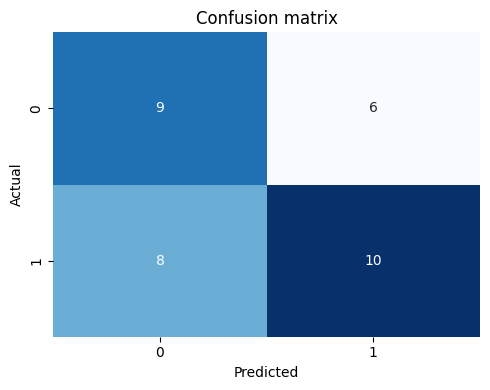

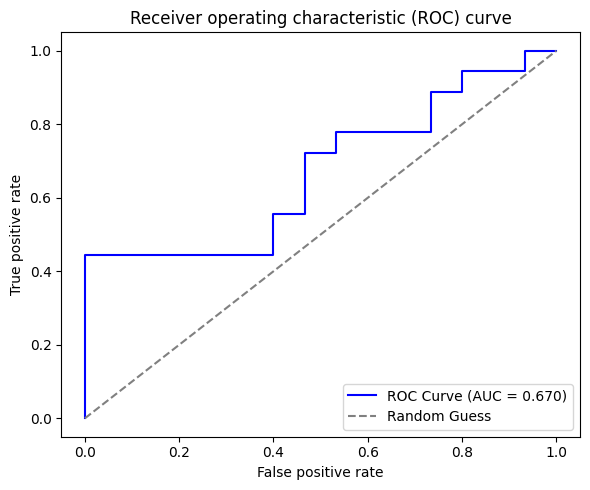

In [67]:
DESC_CSV = "X_1D2D_descriptors.csv"
ORIG_XLSX = "in_chemico_dataset.xlsx"
TARGET_COL = "Phototoxicity"
EXCEL_SKIPROWS = 1

# Output
TOP_FEATURES_CSV = "top_features_best.csv"

# Split train-test
X = pd.read_csv(DESC_CSV)
y = pd.read_excel(ORIG_XLSX, engine="openpyxl", skiprows=EXCEL_SKIPROWS)[TARGET_COL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initial model
base_model = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="logloss",
)
base_model.fit(X_train, y_train)

# Get features
importances = base_model.feature_importances_
feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nTop 10 features:")
print(feat_imp.head(10))

y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nModel metrics")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

# Classification report
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix")
plt.tight_layout()
plt.show()


# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Receiver operating characteristic (ROC) curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


Saved top 49 features -> top_features_best.csv


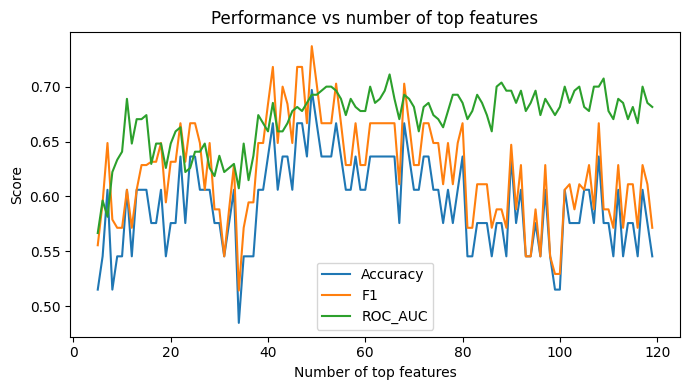


Best number of features: 49
Top_N       49.000000
Accuracy     0.696970
F1           0.736842
ROC_AUC      0.692593
Name: 44, dtype: float64


In [68]:
results = []

for n in range(5, 120, 1):  # test top 5–119 features
    top_feats = feat_imp["feature"].head(n).tolist()

    model = xgb.XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        eval_metric="logloss",
    )
    model.fit(X_train[top_feats], y_train)

    y_pred = model.predict(X_test[top_feats])
    y_prob = model.predict_proba(X_test[top_feats])[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((n, acc, f1, auc))

# Summary
res_df = pd.DataFrame(results, columns=["Top_N", "Accuracy", "F1", "ROC_AUC"])

# Find best by F1 score
best = res_df.iloc[res_df["F1"].idxmax()]
best_n = int(best.Top_N)

# Save the best top features
best_feats = feat_imp.head(best_n)
best_feats.to_csv(TOP_FEATURES_CSV, index=False)
print(f"Saved top {best_n} features -> {TOP_FEATURES_CSV}")

# All in one
plt.figure(figsize=(7,4))
plt.plot(res_df["Top_N"], res_df["Accuracy"], label="Accuracy")
plt.plot(res_df["Top_N"], res_df["F1"], label="F1")
plt.plot(res_df["Top_N"], res_df["ROC_AUC"], label="ROC_AUC")
plt.xlabel("Number of top features")
plt.ylabel("Score")
plt.title("Performance vs number of top features")
plt.legend()
plt.tight_layout()
plt.show()

print("\nBest number of features:", best_n)
print(best)

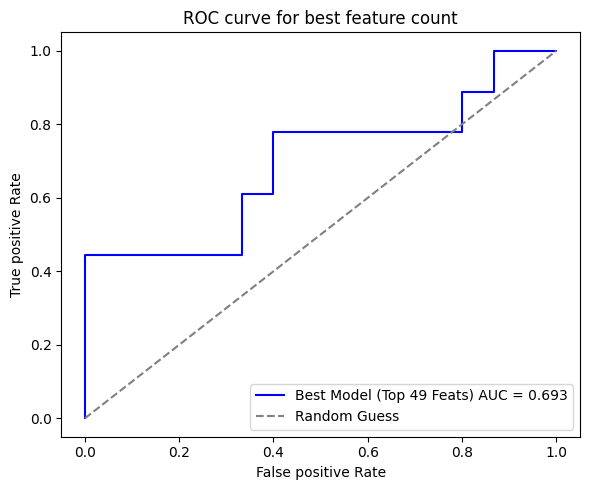

In [69]:
# Best pick
top_feats = feat_imp["feature"].head(best_n).tolist()
final_model = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="logloss",
)
final_model.fit(X_train[top_feats], y_train)

# Predictions for ROC
y_prob_best = final_model.predict_proba(X_test[top_feats])[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
auc_best = roc_auc_score(y_test, y_prob_best)

# Plot ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", label=f"Best Model (Top {best_n} Feats) AUC = {auc_best:.3f}")
plt.plot([0,1],[0,1],"--",color="gray",label="Random Guess")
plt.xlabel("False positive Rate")
plt.ylabel("True positive Rate")
plt.title("ROC curve for best feature count")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()